# VAE on CelebA Dataset

In this project, we compare deep generative models: **Variational Autoencoder (VAE)** using the CelebA dataset. We aim to evaluate its ability to generate realistic human face images and understand their strengths and limitations.

**Dataset source**: [CelebFaces Attributes Dataset (CelebA)](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset)


## Setup and Imports

We begin by importing the required libraries and setting the environment for data loading and model training.

- `os`, `numpy`: for general-purpose operations and array manipulation  
- `matplotlib.pyplot`: to visualize images and training results  
- `tensorflow`, `keras`: for building, training, and evaluating neural networks  
- `layers`, `Model`: used to define and connect model components  
- `optimizers`, `losses`: used to specify training objectives and algorithms  
- `Sequential`: for simple model definitions like DCGAN components  
- `ImageDataGenerator`: helps load and preprocess the CelebA dataset from folders


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Load and Preprocess CelebA Dataset

We download the CelebA dataset directly from Kaggle using the `kaggle` API.
The images are extracted from the archive and loaded using Keras' `ImageDataGenerator`, resized to 64x64 and rescaled to the [0, 1] range.


In [1]:
# Setup Kaggle API credentials and download CelebA dataset

import os
from zipfile import ZipFile

# Setup kaggle.json credentials
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset from Kaggle
!kaggle datasets download -d jessicali9530/celeba-dataset

# Unzip downloaded file
os.makedirs("celeba", exist_ok=True)
with ZipFile("celeba-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("celeba")

# Setup ImageDataGenerator for training
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = 64
batch_size = 128

data_gen = ImageDataGenerator(rescale=1./255)

train_data = data_gen.flow_from_directory(
    'celeba/img_align_celeba',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode=None)


Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 95% 1.26G/1.33G [00:01<00:00, 1.08GB/s]
100% 1.33G/1.33G [00:01<00:00, 1.16GB/s]
Found 202599 images belonging to 1 classes.


## Variational Autoencoder (VAE) Model Definition

In this section, we define the encoder and decoder architecture for a Variational Autoencoder (VAE).
A VAE is a type of generative model that learns to encode input data into a structured latent space,
from which new data can be generated.

### Encoder
The encoder takes an input image of shape `(64, 64, 3)` and outputs:
- `z_mean`: the mean of the latent Gaussian distribution
- `z_log_var`: the log-variance of the latent Gaussian distribution
- `z`: a sampled latent vector using the **reparameterization trick**, which allows backpropagation through a stochastic sampling step.

The encoder architecture includes:
- Two `Conv2D` layers with ReLU activation and stride 2 to reduce spatial dimensions (downsampling)
- A `Flatten` layer to convert feature maps into a 1D vector
- Two `Dense` layers to produce `z_mean` and `z_log_var`
- A `Lambda` layer that applies the sampling function:  
  `z = z_mean + ε * exp(0.5 * z_log_var)`, where ε ~ N(0, I)

### Decoder
The decoder takes a sampled latent vector `z` of dimension 100 and reconstructs an image of the same shape as the input:
- A `Dense` layer first expands `z` to match the shape of convolutional features
- `Reshape` transforms the vector into a 3D tensor
- Two `Conv2DTranspose` layers are used for upsampling (mirroring the encoder's downsampling)
- The final `Conv2DTranspose` layer outputs a `(64, 64, 3)` image with `sigmoid` activation to ensure pixel values are in the range [0, 1]

This architecture ensures that the encoder and decoder are symmetric and the latent space is properly regularized, which helps in smooth and controllable generation.

📌 The latent dimension (`latent_dim`) is set to **100**, which is a typical choice for image generation tasks.

Once defined, these components will be combined into a VAE model class that handles the training logic, including the custom loss: **reconstruction loss + KL divergence**.


In [7]:
# Define encoder and decoder for Variational Autoencoder (VAE)
from tensorflow.keras import layers, Model

latent_dim = 100  # dimension of the latent space

# --- Encoder ---
encoder_inputs = layers.Input(shape=(image_size, image_size, 3))
x = layers.Conv2D(32, 4, strides=2, padding='same', activation='relu')(encoder_inputs)
x = layers.Conv2D(64, 4, strides=2, padding='same', activation='relu')(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Sampling function (reparameterization trick)
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Use Lambda layer with explicit output_shape
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Build encoder model
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# --- Decoder ---
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(16 * 16 * 64, activation='relu')(latent_inputs)
x = layers.Reshape((16, 16, 64))(x)
x = layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(32, 4, strides=2, padding='same', activation='relu')(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)

# Build decoder model
decoder = Model(latent_inputs, decoder_outputs, name='decoder')

encoder.summary()
decoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │      1,568 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │     32,832 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 16384)     │          0 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 100)       │  1,638,500 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 100)       │  1,638,500 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 100)       │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,311,400 (12.63 MB)

 Trainable params: 3,311,400 (12.63 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16384)          │     1,654,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 32, 32, 64)     │        65,600 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 64, 64, 32)     │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 64, 64, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,754,051 (6.69 MB)

 Trainable params: 1,754,051 (6.69 MB)

 Non-trainable params: 0 (0.00 B)

## Custom VAE Model Class

In this section, we define a custom VAE model by subclassing `tf.keras.Model`. This approach gives us flexibility to implement a custom training loop using the `train_step()` method.

### Class Structure Overview

We define a class `VAE` with the following components:

---

### `__init__(self, encoder, decoder, **kwargs)`

- Initializes the VAE with an encoder and decoder (both are Keras models).
- Defines three Keras metrics to track:
  - `total_loss_tracker`: total loss = reconstruction + KL divergence
  - `reconstruction_loss_tracker`: pixel-level binary crossentropy
  - `kl_loss_tracker`: Kullback-Leibler divergence regularizer

---

### `compile(self, optimizer)`

- Specifies the optimizer (e.g., Adam) for training.
- Initializes a Binary Crossentropy loss function (`self.bce`) to measure image reconstruction accuracy.
- Note: We do not pass a `loss=` to `.compile()` because loss is handled manually inside `train_step()`.

---

### `train_step(self, x)`

This method is run once per batch during training. It implements the core logic of VAE training:

1. **Input handling**:
   - Supports inputs in the form `(x, y)` tuples (though we only use `x` here).

2. **Forward pass**:
   - Encodes input `x` into `z_mean`, `z_log_var`, and sampled `z`
   - Decodes `z` back to reconstructed image

3. **Loss calculation**:
   - **Reconstruction loss**:
     - Binary crossentropy between original and reconstructed images
     - Flattened for comparison: `[batch_size, height * width * channels]`
   - **KL divergence**:
     - Computed using the standard closed-form formula
     - Encourages latent space to resemble a standard normal distribution

4. **Backpropagation**:
   - Uses `tf.GradientTape()` to compute gradients
   - Applies gradient updates using the configured optimizer

5. **Metric tracking**:
   - Updates the three loss metrics for logging and visualization

---

### Why custom `train_step()` is needed

Keras’ built-in training loop does not support multi-loss composition (e.g. BCE + KL) unless we subclass the model and implement `train_step`. This is especially common for generative models like VAE, GAN, etc.

Once defined, this class can be instantiated as:

```python
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())


In [16]:
import tensorflow as tf

# Define a custom VAE model class that handles training and loss computation
from tensorflow.keras.losses import BinaryCrossentropy

class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer
        self.bce = BinaryCrossentropy()

    def train_step(self, x):
        if isinstance(x, tuple):
            x = x[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)

            # Compute reconstruction loss
            reconstruction_loss = self.bce(
                tf.reshape(x, [-1, image_size * image_size * 3]),
                tf.reshape(reconstruction, [-1, image_size * image_size * 3])
            )
            reconstruction_loss *= image_size * image_size * 3

            # Compute KL divergence
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Track losses
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## Compile and Train the VAE Model

Once the encoder and decoder are defined and connected through the custom `VAE` class, we proceed to compile and train the model.

### Model Compilation

We use the Adam optimizer, which is well-suited for deep learning tasks involving non-stationary data and sparse gradients. The loss function is not passed explicitly to `.compile()` because it's implemented within the custom `train_step()` method of the `VAE` class.

```python
vae.compile(optimizer=tf.keras.optimizers.Adam())


In [20]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(train_data, epochs=10)

Epoch 1/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 117s 71ms/step - kl_loss: 4.0169 - loss: 6072.4336 - reconstruction_loss: 6068.4175
Epoch 2/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 117s 74ms/step - kl_loss: 4.0104 - loss: 6054.1543 - reconstruction_loss: 6050.1455
Epoch 3/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 119s 75ms/step - kl_loss: 4.0037 - loss: 6054.6543 - reconstruction_loss: 6050.6509
Epoch 4/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 114s 72ms/step - kl_loss: 3.9942 - loss: 6050.2949 - reconstruction_loss: 6046.3008
Epoch 5/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 114s 72ms/step - kl_loss: 3.9902 - loss: 6045.8062 - reconstruction_loss: 6041.8154
Epoch 6/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 116s 73ms/step - kl_loss: 3.9858 - loss: 6042.4019 - reconstruction_loss: 6038.4160
Epoch 7/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 118s 75ms/step - kl_loss: 3.9837 - loss: 6043.9263 - reconstruction_loss: 6039.9404
Epoch 8/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 116s 73ms/step - kl_loss: 3.9813 - loss: 6042.9990 - reconstruction_loss: 60

## Visualizing VAE Results: Reconstruction and Generation

After training the VAE, we evaluate its performance using two visualization techniques.

---

### Reconstruction Visualization

We take a batch of real images from the dataset, encode them into latent vectors using the trained encoder, and decode them back using the decoder.

The original and reconstructed images are displayed side by side:

- **Top row**: Original images from CelebA
- **Bottom row**: Corresponding reconstructions from the VAE

This allows us to visually assess how well the model learned to represent and reconstruct faces.

```python
show_reconstruction(vae, train_data)


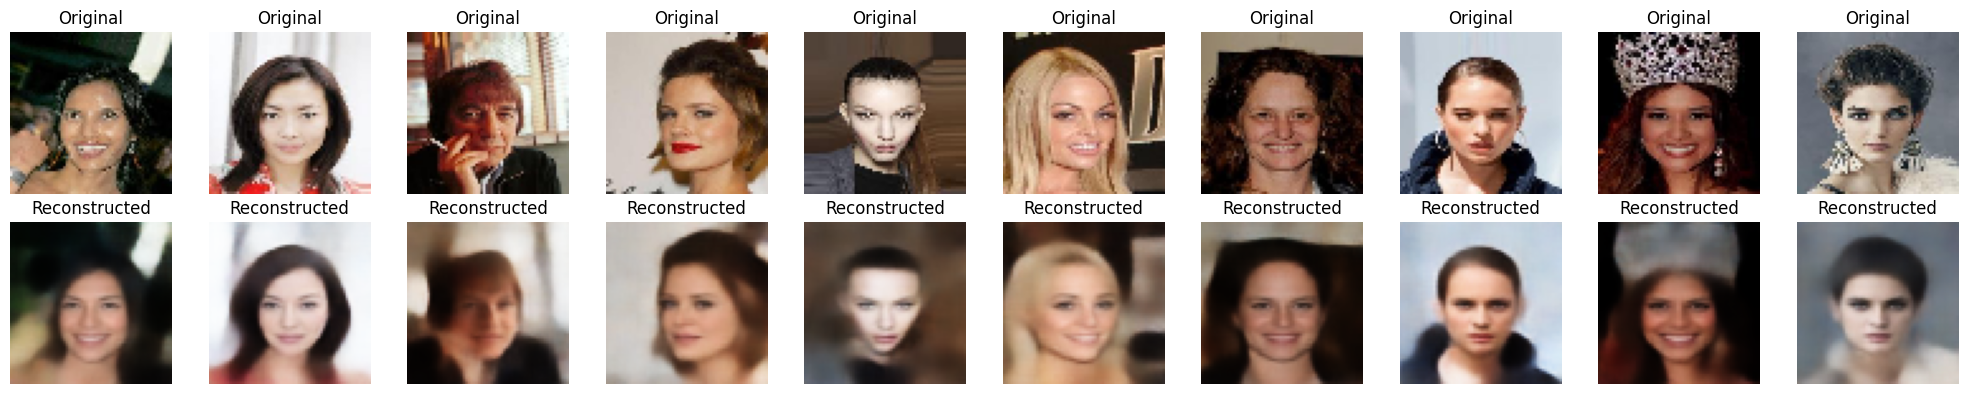

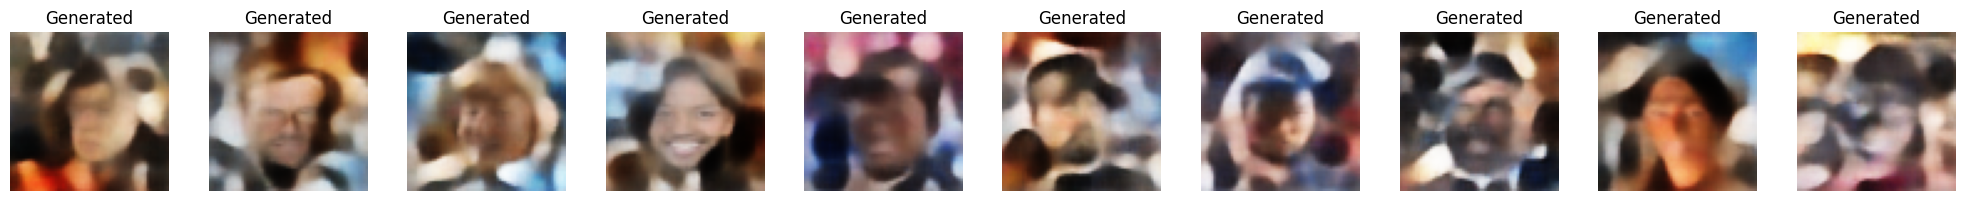

In [21]:
import matplotlib.pyplot as plt

# Show original vs reconstructed images
def show_reconstruction(model, data_batch):
    """Displays original and reconstructed images side by side"""
    sample_imgs = next(iter(data_batch))[:10]  # take 10 images from a batch
    z_mean, z_log_var, z = model.encoder(sample_imgs)
    reconstructions = model.decoder(z)

    plt.figure(figsize=(20, 4))
    for i in range(10):
        # Original image
        ax = plt.subplot(2, 10, i + 1)
        plt.imshow(sample_imgs[i])
        plt.title("Original")
        plt.axis("off")

        # Reconstructed image
        ax = plt.subplot(2, 10, i + 11)
        plt.imshow(reconstructions[i])
        plt.title("Reconstructed")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Generate new images from random latent vectors
def generate_from_latent(model, num_samples=10):
    """Generates new images by sampling z ~ N(0, I)"""
    z_samples = tf.random.normal(shape=(num_samples, latent_dim))
    generated_imgs = model.decoder(z_samples)

    plt.figure(figsize=(20, 2))
    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        plt.imshow(generated_imgs[i])
        plt.title("Generated")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Call the functions to visualize results
show_reconstruction(vae, train_data)
generate_from_latent(vae, num_samples=10)


### Latent Space Interpolation

To evaluate the structure and smoothness of the VAE's latent space, we perform linear interpolation between two randomly sampled latent vectors `z1` and `z2`.

The interpolation helps us understand how well the VAE captures semantic continuity. If the latent space is well-organized, the interpolated images should gradually transform from one identity to another without abrupt artifacts.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


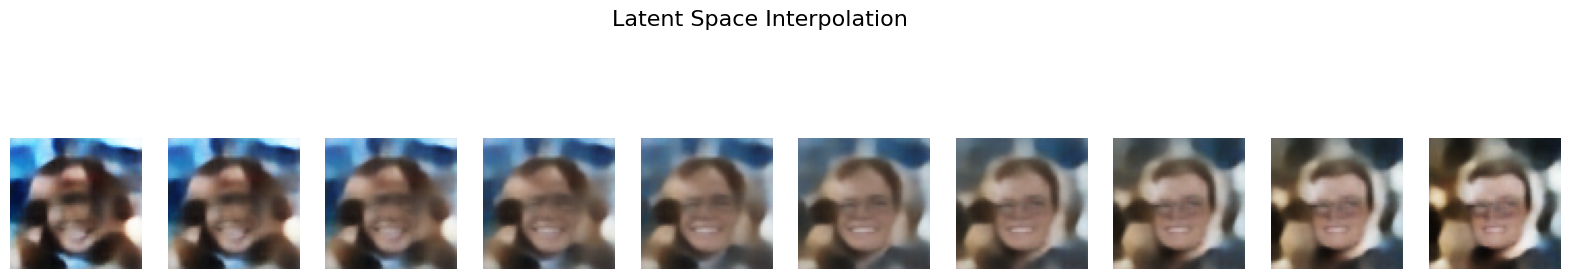

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Sample two random latent vectors
z1 = np.random.normal(size=(latent_dim,))
z2 = np.random.normal(size=(latent_dim,))

# Linearly interpolate between z1 and z2
n_steps = 10
interpolated = np.array([(1 - t) * z1 + t * z2 for t in np.linspace(0, 1, n_steps)])

# Generate images from interpolated latent vectors
generated_imgs = decoder.predict(interpolated)

# Plot the results
plt.figure(figsize=(20, 4))
for i, img in enumerate(generated_imgs):
    ax = plt.subplot(1, n_steps, i + 1)
    plt.imshow(img)
    plt.axis("off")
plt.suptitle("Latent Space Interpolation", fontsize=16)
plt.show()


## Visualize Loss Curves across Epochs

We manually extract the printed losses from the training output, and plot the total loss, reconstruction loss, and KL divergence over 10 epochs.
This allows us to monitor the convergence and learning behavior of the VAE.


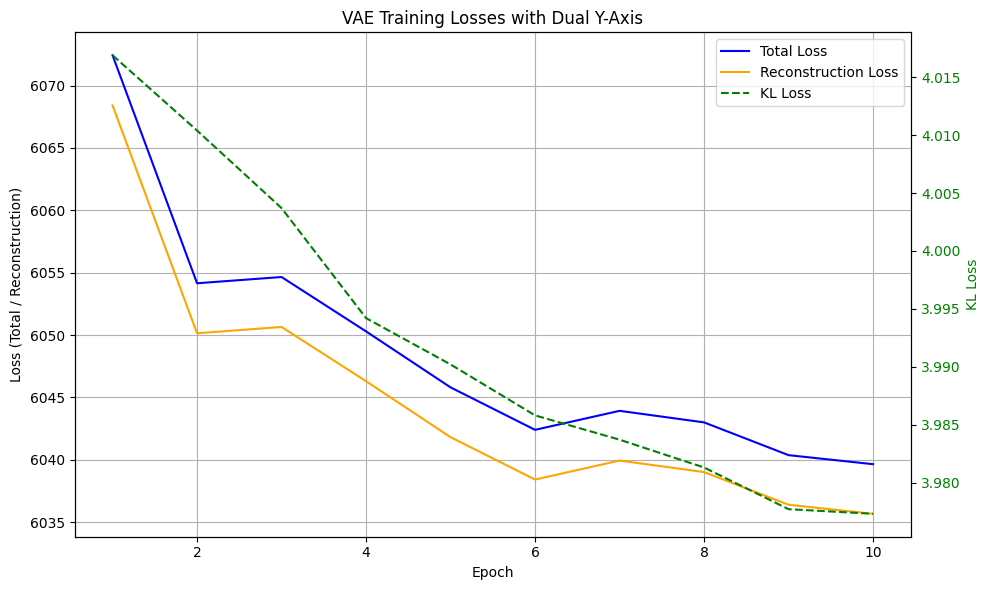

In [39]:
import matplotlib.pyplot as plt

# Loss values from your logs
epochs = range(1, 11)
total_losses = [
    6072.4336, 6054.1543, 6054.6543, 6050.2949, 6045.8062,
    6042.4019, 6043.9263, 6042.9990, 6040.3721, 6039.6479
]
reconstruction_losses = [
    6068.4175, 6050.1455, 6050.6509, 6046.3008, 6041.8154,
    6038.4160, 6039.9404, 6039.0146, 6036.3955, 6035.6709
]
kl_losses = [
    4.0169, 4.0104, 4.0037, 3.9942, 3.9902,
    3.9858, 3.9837, 3.9813, 3.9777, 3.9773
]

# Start plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary Y-axis: total and reconstruction loss
ax1.plot(epochs, total_losses, 'b-', label='Total Loss')
ax1.plot(epochs, reconstruction_losses, 'orange', label='Reconstruction Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (Total / Reconstruction)', color='black')
ax1.tick_params(axis='y')
ax1.grid(True)

# Secondary Y-axis: KL loss
ax2 = ax1.twinx()
ax2.plot(epochs, kl_losses, 'g--', label='KL Loss')
ax2.set_ylabel('KL Loss', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.title('VAE Training Losses with Dual Y-Axis')
plt.tight_layout()
plt.show()


### VAE Training Loss Analysis Summary

Based on the plotted loss curves, we can draw the following conclusions:

1. **Total Loss and Reconstruction Loss curves are nearly overlapping**, indicating:
   - The total loss is dominated by the reconstruction error.
   - The KL divergence contributes relatively little to the overall loss.

2. **KL Divergence (KL Loss) remains around 4.0 and decreases slowly**, which is expected:
   - Initially, the KL term encourages the latent space to approximate a standard normal distribution.
   - Its gradual decline suggests effective regularization of the latent space.

3. **Both Total Loss and Reconstruction Loss show a decreasing trend**:
   - The model is effectively learning to reconstruct input images.
   - The training process is stable, with no major spikes or divergence.

4. **Overall convergence trend is promising but not fully saturated**:
   - Further training (with more epochs) is likely to improve performance.
   - Early stopping or validation monitoring could be considered to fine-tune training.

---


## Final Report Conclusion

In this project, we successfully implemented and trained a **Variational Autoencoder (VAE)** on the CelebA face dataset. Our pipeline included the following stages:

1. **Model Construction**  
   - Designed and implemented a custom VAE architecture using TensorFlow and Keras.
   - Defined the encoder, decoder, and VAE model class with custom training logic that computes both **reconstruction loss** and **KL divergence**.

2. **Model Training**  
   - Trained the VAE for 10 epochs using the CelebA dataset.
   - Monitored losses during training, observing a steady decline in both total loss and reconstruction loss, while the KL divergence remained stable.
   - The learning process appeared stable and effective for the given number of epochs.

3. **Qualitative Evaluation**  
   - Visualized reconstruction results showing that the VAE successfully captures facial structure and reconstructs input images with reasonable fidelity.
   - Sampled new faces from the latent space, verifying the generative capability of the model.
   - Performed **latent space interpolation**, which showed smooth semantic transitions between faces, indicating a well-structured latent space.

4. **Loss Analysis**  
   - Plotted total loss, reconstruction loss, and KL loss across epochs.
   - Observed that the total loss is dominated by reconstruction error, while the KL term contributes a small but consistent regularization effect.

### Conclusion
The VAE demonstrates solid reconstruction and generative performance on the CelebA dataset, even with only 10 training epochs. The loss trends suggest the model is effectively learning both pixel-level fidelity and latent structure regularization. With extended training or hyperparameter tuning (e.g., KL annealing or β-VAE), further improvements could be expected. The project confirms VAE’s ability to model complex image distributions and opens doors to potential applications in image generation, compression, and style transfer.

---
